In [1]:
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
import sys
sys.path.append('../')  # Add parent directory to the Python path

import package_DBR
import package_LAB

from importlib import reload
package_DBR = reload (package_DBR)
package_LAB = reload(package_LAB)

from package_LAB import *
from package_DBR import *

from IPython.display import display, clear_output

from datetime import datetime
import tclab
import time

import os

# Parameters

In [2]:
# Simulation Parameters
TSim = 4000          # Total simulation time
Ts=1                 # Sampling time
N = int(TSim/Ts)+1   #simulation steps
alpha = 1 #0.27      # Filter coefficient : T_FD = alpha*T_D
MVMin = 0
MVMax = 100

# Working Point
MV0 = 50           #Manipulated V, Process V, Disturbance V
PV0 = 58           # from our own experience
DV0 = 50


#--------Process------------
# Values from "Identification of SOPDT Model."
# In-Out Dynamics
Kp = 0.36             # Process gain (affect MV and PV)
T1p = 201           # speed of the process response
T2p = 8         # Slight delay in the response
thetap = 8          # Dead time : time delay between MV change and PV change.time delay between MV change and PV change.


# Disturbance Dynamics
Kd = 0.23            #  Disturbance gain : Affects the impact of the disturbance on PV.
T1d = 270            #  how quickly the disturbance affects the PV.
T2d = 31             #  delay in the disturbance effect
thetad = 31        #  Dead time : time delay between a change in the disturbance and its effect on PV


#----------Controller-----------
# Tuning§
gamma = 0.6           # Tuning parameter for the IMC
Kc, Ti, Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')

Kc = Kc/2   # to adjust the integral spike

print('Kc = ', Kc)   # Controller gain : contrôle temps de réaction, aussi l'erreur statique mais celle-ci +facile a corriger avec Integral.
print('Ti = ', Ti)   # Controller integral time constant : Gradual and continuing action until a zero steady-state response E=0 (increasing Ti = decreasing Integral Action)
print('Td = ', Td)   # Controller derivative time constant :  faster response to process changes

print('T1d/Ti, T2d/TI = ', T1d/Ti, " , ", T2d/Ti)  # needs to be < 0.25


Kc =  2.2572144461724557
Ti =  209
Td =  7.69377990430622
T1d/Ti, T2d/TI =  1.291866028708134  ,  0.14832535885167464


# Scenarios (Paths)

In [3]:
scenario = "CLP+FF"

# # Scenario 1: OLP + no FF
if scenario == "OLP+noFF":
    ManPath = {0: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath = {0: PV0, TSim: PV0}
    DVPath = {0: 50, 1200: 60, TSim: 60}
    ActivateFF = False
    ManFF = True

## Scenario 2: OLP + FF
if scenario == "OLP+FF":
    ManPath ={0: True, TSim: True}
    MVManPath = {0: MV0, TSim: MV0}
    SPPath ={0: PV0, TSim: PV0}
    DVPath = {0: 50.0, 1200: 60, TSim: 60.0}
    ActivateFF = True
    ManFF = True

## Scenario 3: CLP + no FF
if scenario == "CLP+noFF":
    ManPath = {0: True, 500: False, TSim: False} 
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0+5, 1500: PV0-5, TSim: PV0-5} 
    DVPath = {0: DV0, 2300: DV0+10, TSim: DV0+10}
    ActivateFF = False
    ManFF = False

# # Scenario 4: CLP + FF
if scenario == "CLP+FF":
    ManPath = {0: True, 500: False, TSim: False} 
    MVManPath = {0: MV0+10, TSim: MV0+10} 
    SPPath = {0: PV0+5, 1500: PV0-5, TSim: PV0-5} 
    DVPath = {0: DV0, 2900: DV0+20, TSim: DV0+10}
    ActivateFF = True
    ManFF = False

# Real-time control and visualisation

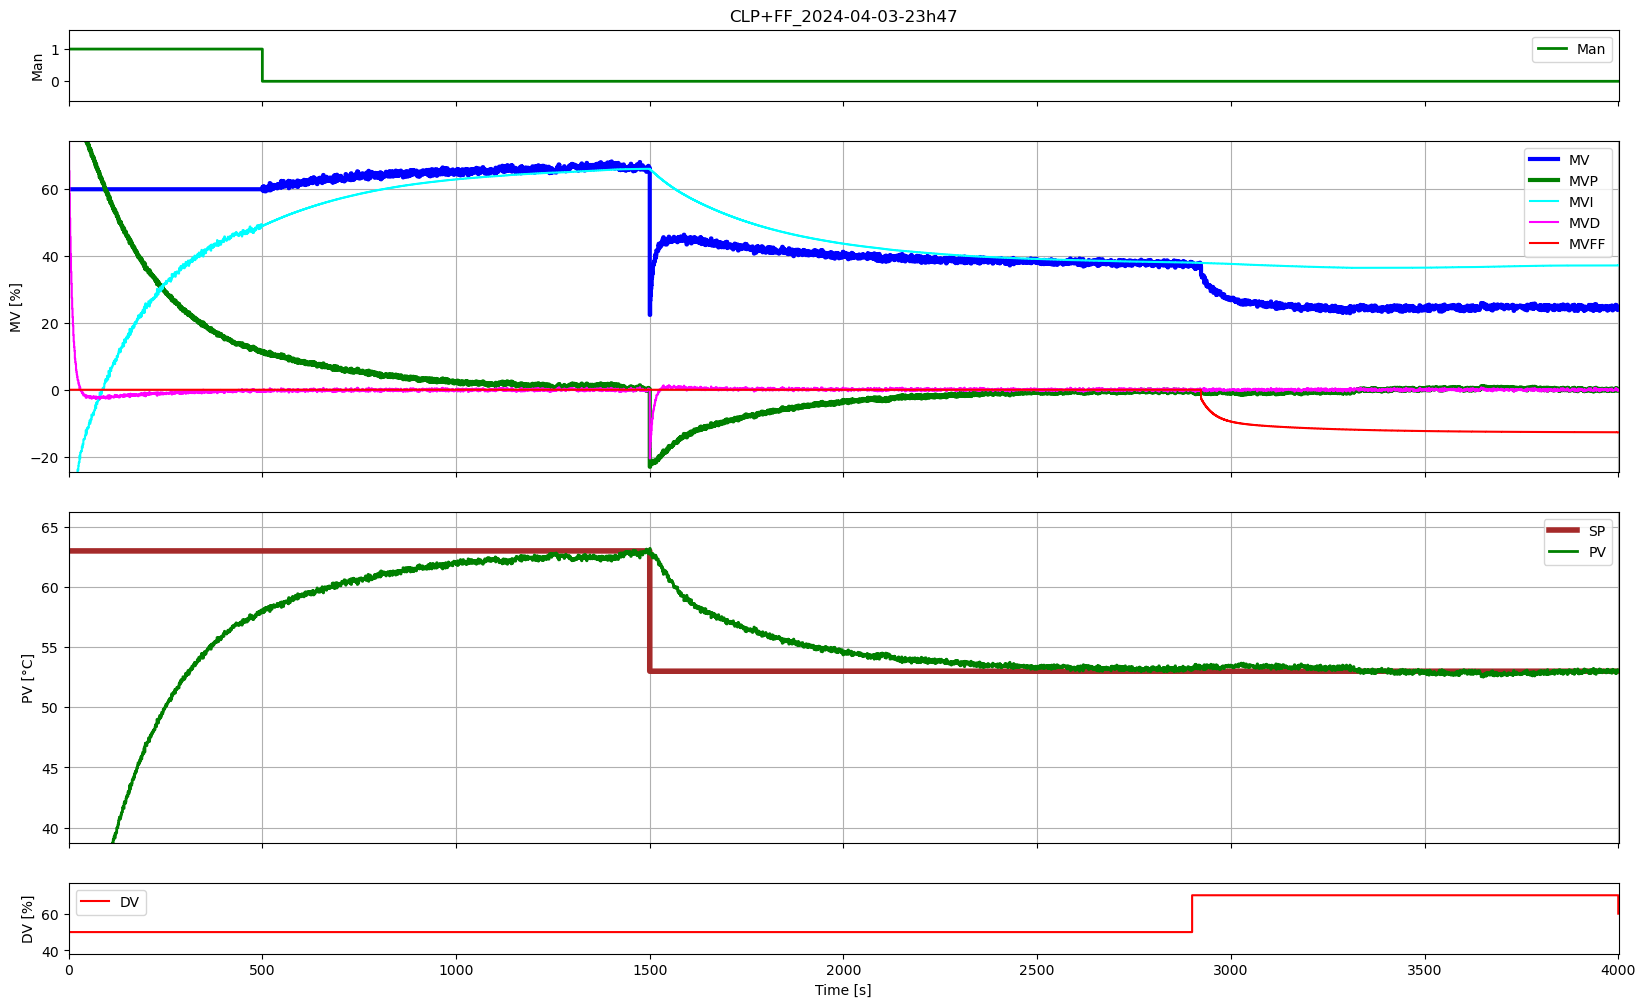

TCLab disconnected successfully.


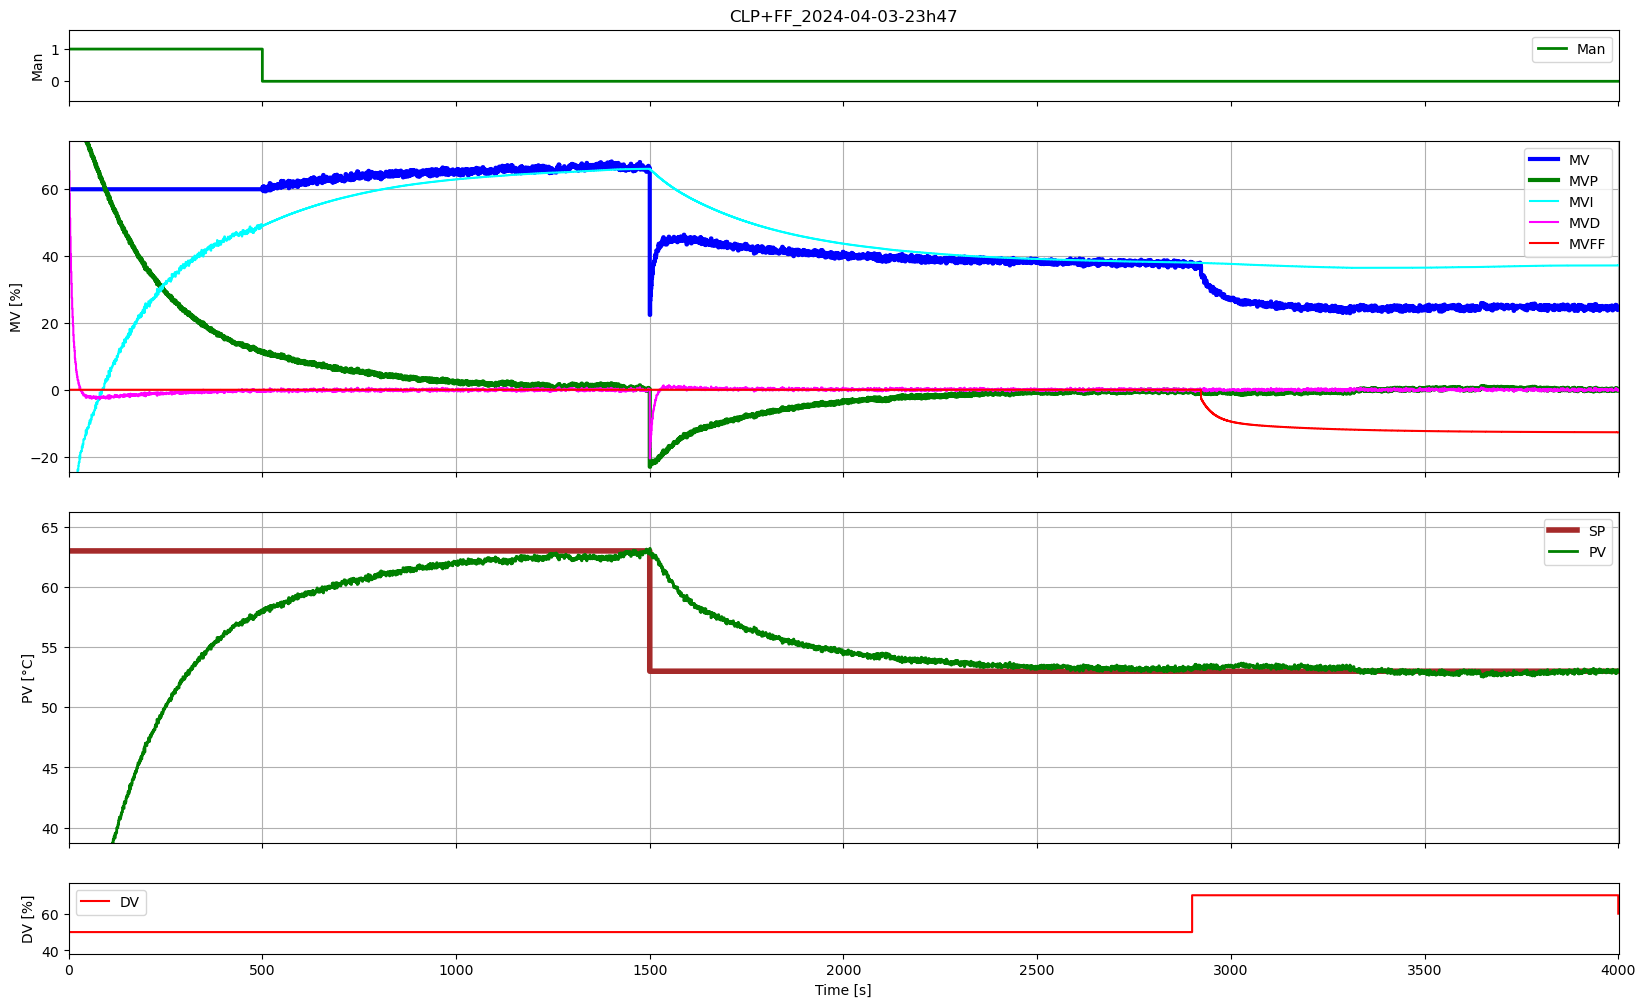

In [4]:
t = []
SP = []
MV = []
Man = []
MVMan = []
MVFF = []
MVP = []
MVI = []
MVD = []
DV = []
PV = []
E = []

MVFFDelay = []
MVFFLL1 = []

lab = tclab.TCLab() #connection to TCLab

now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4,ncols=1, sharex='col', gridspec_kw={'height_ratios': [1.5, 7, 7, 1.5]})
fig.set_figheight(12)
fig.set_figwidth(20)

#------MAN--------
limSup = 1.5
limInf = -0.5
l1, = ax1.step([0,TSim], [limInf,limSup], 'green',linewidth=2, label='Man', where="post")
ax1.set_ylabel('Man')
ax1.set_title(scenario + '_' + date_time)
ax1.legend (loc='best')

#-------MV_MVP_MVI_MVD_MVFF--------------
limSup = 70
limInf = -20
l2, = ax2.step([0, TSim], [limInf,limSup], 'blue', linewidth=3, label='MV', where='post') 
l3, = ax2.step([0, TSim], [limInf,limSup], 'green', linewidth=3, label='MVP', where='post') 
l4, = ax2.step([0, TSim], [limInf,limSup], 'cyan', label='MVI', where='post')
l5, = ax2.step([0, TSim], [limInf,limSup], 'magenta', label='MVD', where='post')
l6, = ax2.step([0, TSim], [limInf,limSup], 'red', label='MVFF', where='post') 
ax2.set_ylabel('MV [%]')
ax2.legend (loc='best')

#----SP_and_PV---------
limSup = 65
limInf = 40
l7, = ax3.step([0, TSim], [limInf,limSup], 'brown', linewidth=4, label='SP', where="post")
l8, = ax3.step([0, TSim], [limInf,limSup], 'green', linewidth=2, label='PV', where='post')
ax3.set_ylabel('PV [°C]')
ax3.legend (loc='best')

#-------DV-------------
limSup=75
limInf = 40
l9, = ax4.step([0, TSim], [limInf,limSup], 'red', label='DV', where='post')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('DV [%]')
ax4.legend (loc='best')

#-----------Experimentation-------------------
for i in range(0, N):
    t.append(i*Ts)

    if t[-1] == 0:
        last_time = time.time()    

    #Process Value
    PV.append(lab.T1)
    
    # Inputs SP, DV
    SelectPath_RT(SPPath, t, SP)
    SelectPath_RT(DVPath, t, DV)

    # Apply DV
    lab.Q2(DV[-1])

    # Feedforward   voir schema vert rouge bleu
    Delay_RT(DV - DV0*np.ones_like(DV), np.max([thetad-thetap, 0]), Ts, MVFFDelay)
    LL_RT(MVFFDelay, -Kd/Kp, T1p, T1d, Ts, MVFFLL1)
    if ActivateFF:
        LL_RT(MVFFLL1, 1, T2p, T2d, Ts, MVFF)
    else:
        LL_RT(MVFFLL1, 0, T2p, T2d, Ts, MVFF)

    # PID control action
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath, t, MVMan)
    # print("Kc = ", Kc)
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E, ManFF=False, PVInit=PV0, method='EBD-EBD')

    # MV
    lab.Q1(MV[-1])
    
    # Wait for sampling period Ts
    now = time.time()
    delta = now - last_time
    
    time.sleep(np.max([0, Ts - delta]))
    last_time = time.time()  

    #-----Set Data-----
    l1.set_data(t, Man)
    l2.set_data(t,MV)
    l3.set_data(t, MVP)
    l4.set_data(t,MVI)
    l5.set_data(t, MVD)
    l6.set_data(t, MVFF)
    l7.set_data(t, SP)
    l8.set_data(t, PV)
    l9.set_data(t, DV)

    clear_output(wait=True)

    ax1.set_xlim(0, t[-1]+1)
    ax2.set_xlim(0, t[-1]+1)
    ax3.set_xlim(0, t[-1]+1)
    ax4.set_xlim(0, t[-1]+1)

    ax2.grid()
    ax3.grid()

    display(fig)
    
lab.close() # Disconnect from TCLab

#---------------------------Saving datas----------------------------
# Save data in text file
# ----------------------
now = datetime.now()
date_time = now.strftime("%Y-%m-%d-%Hh%M")
# Conversion to array
t = np.array(t)
MV = np.array(MV)
MVP = np.array(MVP)             
MVI = np.array(MVI)             
MVD = np.array(MVD)    
MVFF = np.array(MVFF) 
SP = np.array(SP) 
PV = np.array(PV) 
DV = np.array(DV)   
Man = np.array(Man) 
my_data = np.vstack((t.T,MV.T,MVP.T,MVI.T,MVD.T,MVFF.T,SP.T,PV.T,DV.T,Man.T))
my_data = my_data.T
nameFile = 'Data/Experiment_' + scenario + '_' + date_time + '.txt'
if not os.path.exists('Data'):
    os.makedirs('Data')
np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,MVP,MVI,MVD,MVFF,SP,PV,DV,Man',comments='')     


# Save Plot
# ---------
if not os.path.exists('Plots'):
    os.makedirs('Plots')

nameFile = 'Plots/Experiment_' + scenario + '_' + date_time
plt.savefig(nameFile + '.png',transparent=True)            
plt.savefig(nameFile + '.pdf',transparent=True)  